In [1]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [2]:
df = pd.read_csv('sample_clean_100_15k.csv')

In [3]:
df.head()

,artist,song_name,closest_genre,lyric,length_lyric,actual_lyric_length
0,Memphis Minnie,He's In the Ring (Doin' the Same Old Thing),Blues,If Simon says be glad today\nI surely do what ...,162,32
1,The Supremes,Where Did Our Love Go,Blues,"(Brian Holland/Lamont Dozier/Edward Holland, J...",224,45
2,The Miracles,You Really Got A Hold On Me,Blues,I don't like you\nBut I love you\nSee that I'm...,185,37
3,Marvin Gaye,What's Going On,Blues,"Mother, mother\nThere's too many of you crying...",162,33
4,Stevie Wonder,I Wish,Blues,Looking back on when I\nWas a little nappy hea...,250,45


In [4]:
eng_stopwords = stopwords.words('english')
# eng_stopwords.extend(['yeah','oh', , ])

In [5]:
def stopwords_removing(text):
     return ' '.join([word for word in text.split() if not(word in eng_stopwords)])

In [6]:

df['lyric_processed'] = df.lyric.map(lambda x: re.sub('[(),\.!?]', '', x))
df['lyric_processed'] = df.lyric_processed.map(lambda x: x.lower())
df['lyric_processed'] = df.lyric_processed.map(lambda x: stopwords_removing(x))
df.lyric_processed.head()

0    simon says glad today surely simon say youl li...
1    brian holland/lamont dozier/edward holland jr ...
2    like love see i'm always thinking oh oh oh tre...
3    mother mother there's many crying brother brot...
4    looking back little nappy headed boy worry chr...
Name: lyric_processed, dtype: object

In [7]:
long_string = ','.join(df.lyric_processed.to_list())

In [8]:
wordcloud = WordCloud(max_words=5000, contour_width=3, contour_color='steelblue', background_color='white')

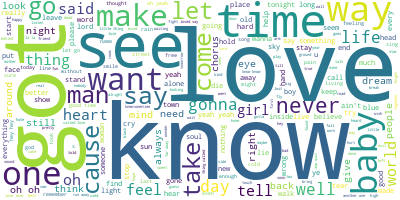

In [9]:
wordcloud.generate(long_string)
wordcloud.to_image()

In [10]:
# per genre
for genre in df.closest_genre.unique():
    print(f'{genre}')
    dt = df.query(f'closest_genre=="{genre}"')
    long_string = ','.join(dt.lyric_processed.to_list())
    wordcloud = WordCloud(max_words=5000, contour_width=3, contour_color='steelblue', background_color='white')
    wordcloud.generate(long_string)
    wordcloud.to_file(f'{genre}_5000words_cleaned.png')

Blues
Country
Electronic
Folk
Hip Hop
Jazz
Metal
Pop
Punk
Reggae
Rock


In [11]:
# Prepare data for LDA Analysis
import gensim
from gensim.utils import simple_preprocess
eng_stopwords.extend(['from', 'subject', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))

data = df.lyric_processed.to_list()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['simon', 'says', 'glad', 'today', 'surely', 'simon', 'say', 'youl', 'like', 'see', 'smile', 'luck', 'cause', 'that', 'style', 'pretty', 'bird', 'tree', 'hear', 'song', 'sing', 'sky', 'fantastic', 'blue', 'grey', 'alive', 'today', 'hey', 'simple', 'things']


In [12]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)

texts = data_words

corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 3), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1)]


In [13]:
from pprint import pprint

In [23]:
num_topics = 25

lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

pprint(lda_model.print_topics())

C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(17,
  '0.019*"say" + 0.019*"love" + 0.018*"bicycle" + 0.013*"want" + 0.011*"gonna" '
  '+ 0.010*"we" + 0.009*"re" + 0.009*"ride" + 0.009*"night" + 0.007*"oh"'),
 (18,
  '0.014*"know" + 0.014*"man" + 0.009*"take" + 0.007*"see" + 0.006*"day" + '
  '0.006*"gonna" + 0.006*"want" + 0.006*"got" + 0.005*"time" + 0.005*"away"'),
 (24,
  '0.027*"love" + 0.015*"ll" + 0.011*"ve" + 0.011*"know" + 0.010*"there" + '
  '0.010*"can" + 0.010*"got" + 0.009*"time" + 0.008*"way" + 0.008*"gonna"'),
 (3,
  '0.029*"could" + 0.016*"say" + 0.016*"love" + 0.015*"something" + '
  '0.012*"loved" + 0.011*"reggae" + 0.011*"like" + 0.009*"music"

In [15]:
doc_lda = lda_model[corpus]

In [16]:
# Analyizing LDA model results

import pyLDAvis.gensim
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('lda_results/ldavis_cleaned_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, LDAvis_data_filepath+'.html')

LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.005456  0.010511       1        1  7.706941
8     -0.014223  0.010769       2        1  7.675215
0     -0.009895  0.012231       3        1  7.665066
19     0.002016  0.006882       4        1  7.145928
10    -0.066296  0.015087       5        1  6.798204
14     0.023614  0.015961       6        1  6.152039
2     -0.008125  0.005723       7        1  6.111384
1     -0.015503  0.018862       8        1  5.996236
9      0.010915 -0.023181       9        1  5.899662
5     -0.025094  0.082753      10        1  5.892558
16    -0.013132 -0.007867      11        1  4.289168
13    -0.004928 -0.045848      12        1  4.250176
17     0.019566 -0.066866      13        1  4.002340
15     0.024051  0.013136      14        1  3.817092
6      0.018262 -0.016236      15        1  3.724230
11     0.001133  0.043290      16        1  2.898638
7      0.012824  0.003548      17        1  2.697050
3     -0.063864 -0.044220      18        1  2.621894
12    -0.003459 -0.047394      19        1  2.403582
4      0.106684  0.012859      20        1  2.252594, topic_info=      Term         Freq        Total Category  logprob  loglift
5    could   643.000000   643.000000  Default  30.0000  30.0000
79   loved   267.000000   267.000000  Default  29.0000  29.0000
78    love  1892.000000  1892.000000  Default  28.0000  28.0000
117   want   608.000000   608.000000  Default  27.0000  27.0000
50    away   535.000000   535.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
267   time    13.575614   774.968838  Topic20  -5.3062  -0.2515
86   never    13.162217   717.433477  Topic20  -5.3371  -0.2052
383   take    12.488833   524.774996  Topic20  -5.3896   0.0550
100     ve    12.438747   596.754513  Topic20  -5.3937  -0.0776
30     see    11.905392   658.427414  Topic20  -5.4375  -0.2198

[1542 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3467      6  0.840454  aaaaaah
1168      2  0.526743   aaahhh
1168      3  0.105349   aaahhh
1168     13  0.210697   aaahhh
6638      3  0.156705    abuse
...     ...       ...      ...
9031      2  0.538804      yoy
9031      7  0.368655      yoy
9031      9  0.070895      yoy
1653     12  0.703295     憆you
1653     18  0.234432     憆you

[6119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 9, 1, 20, 11, 15, 3, 2, 10, 6, 17, 14, 18, 16, 7, 12, 8, 4, 13, 5])

In [24]:
# LSI
num_topics = 25

lsi_model = gensim.models.LsiModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

pprint(lsi_model.print_topics())

C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(0,
  '0.450*"love" + 0.293*"could" + 0.258*"say" + 0.253*"oh" + 0.196*"know" + '
  '0.173*"loved" + 0.160*"baby" + 0.152*"something" + 0.150*"got" + '
  '0.145*"yeah"'),
 (1,
  '0.609*"could" + 0.411*"loved" + 0.330*"say" + 0.328*"something" + '
  '-0.278*"love" + -0.105*"baby" + -0.101*"know" + -0.098*"yeah" + -0.097*"oh" '
  '+ -0.084*"like"'),
 (2,
  '0.786*"love" + -0.180*"oh" + -0.172*"know" + -0.141*"ll" + -0.126*"got" + '
  '-0.119*"go" + -0.116*"we" + -0.113*"like" + -0.102*"come" + -0.101*"time"'),
 (3,
  '-0.814*"oh" + -0.208*"run" + -0.202*"away" + 0.181*"we" + 0.147*"jammin" + '
  '0.140*"ll" + 0.138*"r

In [25]:
doc_lsi = lsi_model[corpus]

C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# # Analyizing LSI model results


LSIvis_data_filepath = os.path.join('lda_results/lsivis_cleaned_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LSIvis_prepared = pyLDAvis.gensim.prepare(lsi_model, corpus, id2word)
    with open(LSIvis_data_filepath, 'wb') as f:
        pickle.dump(LSIvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LSIvis_prepared = pickle.load(f)
pyLDAvis.save_html(LSIvis_prepared, LSIvis_data_filepath+'.html')

LSIvis_prepared


C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
lsi_model.get_topics()

C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 1.31261606e-02,  1.62525307e-03,  2.00456246e-02, ...,
         2.28558321e-05,  2.28558321e-05,  8.21838893e-05],
       [ 1.21652681e-02, -8.56849870e-04, -1.11282097e-02, ...,
        -1.55186330e-05, -1.55186330e-05, -8.32302694e-06],
       [-8.79303119e-03, -1.18349454e-03, -1.46536635e-02, ...,
        -4.50370061e-05, -4.50370061e-05, -1.37389470e-04],
       ...,
       [-4.16629837e-03, -3.95486996e-03, -4.35726230e-02, ...,
        -1.44640124e-04, -1.44640124e-04, -5.35254651e-04],
       [ 1.63861858e-03,  2.10440599e-03,  1.03974239e-02, ...,
        -9.60738278e-05, -9.60738278e-05,  4.28363786e-04],
       [-8.01087162e-03, -9.91459937e-04,  8.21172810e-02, ...,
         1.37339586e-05,  1.37339586e-05, -9.45013757e-05]])

In [30]:
topic_mat = lsi_model.get_topics()

C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
topic_mat.shape

C:\Users\glaci\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(25, 9639)